In [216]:
import numpy as np
CONSTS = {
    'R': 1.0,
    'CENTER': np.array([1.2, 1.2, 1.2]),
    'N': int(10e5),
    'A': 2.4
}

# Sphere Volume

In [217]:
from numba import jit

## SEED
np.random.seed = 42

def sphere_volume(R:float) -> float:
    return (4/3)*np.pi*R*R*R

@jit(nopython=True)
def sphere_volume_MC(R:float, A:float, center:np.ndarray[float] ,N:int) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    sqaure_vol:float = A**3
    sum:float = 0.0
    sum_of_squares:float = 0.0

    step = np.zeros(int(N/100))
    expected = np.zeros(int(N/100))
    variance = np.zeros(int(N/100))

    for i in range(1, N + 1):
        # Random Point
        new_point = np.random.uniform(0, A, size=3)

        # result
        dist_sq = np.sum((new_point - center)**2, axis=0)
        multiplyer = 1.0 if dist_sq <= R*R else 0.0

        # Sums
        sum += sqaure_vol * multiplyer
        sum_of_squares += (sqaure_vol * multiplyer)*(sqaure_vol * multiplyer)

        # Checkpoints
        if i%100==0:
            idx = int(i/100) - 1
            step[idx] = i
            expected[idx] = sum/i
            variance[idx] = sum_of_squares/i - (sum/i)*(sum/i)

    std = np.sqrt(variance/N)
    return step, expected, std



## Results

Błąd Oszacowania = 0.0065726112198749576


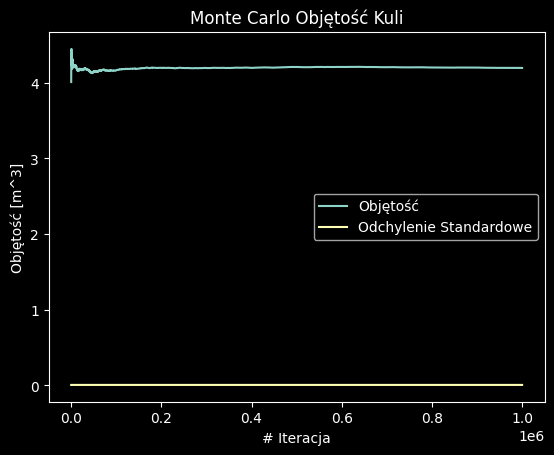

In [218]:
import matplotlib.pyplot as plt

step, expected, std = sphere_volume_MC(CONSTS['R'], CONSTS['A'], CONSTS['CENTER'] ,CONSTS['N'])
error = np.abs(expected[-1] - sphere_volume(CONSTS['R']))
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='Objętość')
plt.plot(step,std, label='Odchylenie Standardowe')
plt.xlabel('# Iteracja')
plt.ylabel('Objętość [m^3]')

plt.legend()
plt.title('Monte Carlo Objętość Kuli')
plt.show()

# Moment of Interia

In [219]:
def sphere_interia(R:float) -> float:
    return (2/5)*(4/3)*np.pi*R*R*R*R*R

@jit(nopython=True)
def sphere_interia_MC(R:float, A:float, center:np.ndarray[float], axis:np.ndarray[float] ,N:int) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    sqaure_vol:float = A**3
    sum:float = 0.0
    sum_of_squares:float = 0.0

    step = np.zeros(int(N/100))
    expected = np.zeros(int(N/100))
    variance = np.zeros(int(N/100))

    for i in range(1, N + 1):
        # Random Point
        new_point = np.random.uniform(0, A, size=3)

        # result
        dist_sq = np.sum((new_point - center)**2, axis=0)
        multiplyer = 1.0 if dist_sq <= R*R else 0.0

        # Sums
        dist_ax_sq = np.sum((new_point[0:2] - axis)**2, axis=0)
        sum += (multiplyer * sqaure_vol * dist_ax_sq)
        sum_of_squares += (multiplyer * sqaure_vol * dist_ax_sq)**2

        # Checkpoints
        if i%100==0:
            idx = int(i/100) - 1
            step[idx] = i
            expected[idx] = sum/i
            variance[idx] = sum_of_squares/i - (sum/i)*(sum/i)
    std = np.sqrt(variance/N)
    return step, expected, std



## Results

Błąd Oszacowania = 0.00031056624400571664


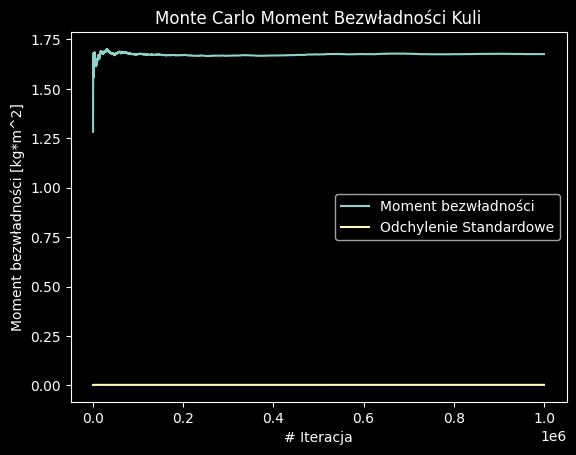

In [220]:
import matplotlib.pyplot as plt

step, expected, std = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], CONSTS['CENTER'][0:2], CONSTS['N'])
error = np.abs(expected[-1] - sphere_interia(CONSTS['R']))
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='Moment bezwładności')
plt.plot(step,std, label='Odchylenie Standardowe')
plt.xlabel('# Iteracja')
plt.ylabel('Moment bezwładności [kg*m^2]')
plt.legend()
plt.title('Monte Carlo Moment Bezwładności Kuli')
plt.show()

# Steiner Theorem

Błąd Oszacowania = 0.0032345446912864784


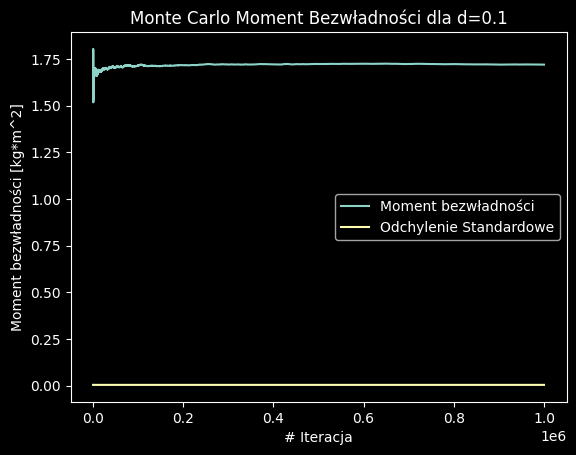

In [221]:
def steiner(I_0:float, m:float, d:float):
    return I_0 + m*d**2

p_0 = np.array([1.3, 1.2])
I_0 = sphere_interia(CONSTS['R'])
d = 0.1
M = sphere_volume(CONSTS['R'])

I = steiner(I_0, M, d)

step, expected, std = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], p_0, CONSTS['N'])
error = np.abs(expected[-1] - I)
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='Moment bezwładności')
plt.plot(step,std, label='Odchylenie Standardowe')
plt.xlabel('# Iteracja')
plt.ylabel('Moment bezwładności [kg*m^2]')
plt.legend()
plt.title('Monte Carlo Moment Bezwładności dla d=0.1')
plt.show()

# New Parameters

Błąd Oszacowania = 0.0017457952136092914


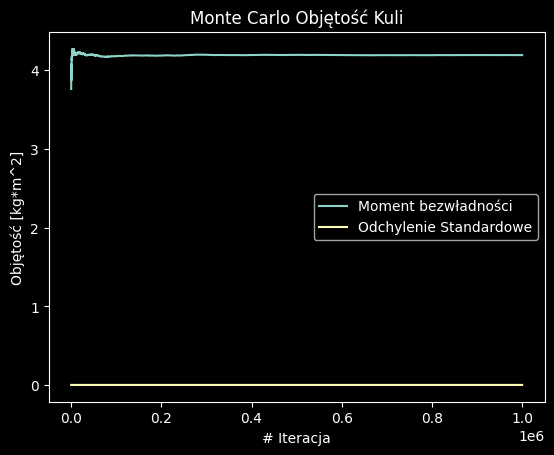

Błąd Oszacowania = 0.0018676953939398278


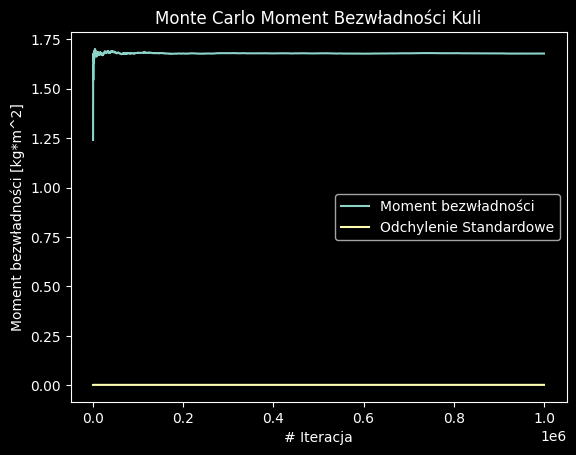

In [222]:
CONSTS['A'] = 2
CONSTS['CENTER'] = np.array([1,1,1])

step, expected, std = sphere_volume_MC(CONSTS['R'], CONSTS['A'], CONSTS['CENTER'] ,CONSTS['N'])
error = np.abs(expected[-1] - sphere_volume(CONSTS['R']))
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='Moment bezwładności')
plt.plot(step,std, label='Odchylenie Standardowe')
plt.xlabel('# Iteracja')
plt.ylabel('Objętość [kg*m^2]')
plt.legend()
plt.title('Monte Carlo Objętość Kuli')
plt.show()

step, expected, std = sphere_interia_MC(CONSTS['R'],CONSTS['A'], CONSTS['CENTER'], CONSTS['CENTER'][0:2],CONSTS['N'])
error = np.abs(expected[-1] - sphere_interia(CONSTS['R']))
print(f'Błąd Oszacowania = {error}')

plt.plot(step,expected,label='Moment bezwładności')
plt.plot(step,std, label='Odchylenie Standardowe')
plt.xlabel('# Iteracja')
plt.ylabel('Moment bezwładności [kg*m^2]')
plt.legend()
plt.title('Monte Carlo Moment Bezwładności Kuli')
plt.show()